In [1]:
# main imports
import os
import sys
import glob
import math
import shutil
import random
import importlib
import subprocess

import numpy as np
import pandas as pd

from itertools import product

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from joypy import joyplot

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "") # directory to where definitions.py is
%aimport definitions

In [8]:
# paths

base_dir = "" # base directory for the analysis

orfanage_bin = "orfanage" # path to the orfanage binary
gffcompare_bin = "" # path to the gffcompare binary
gffread_bin = "" # path to the gffread binary
igvtools_bin = "" # path to the igvtools binary
sashimi_bin = "" # path to the sashimi.py binary (from the TieBrush package)

fa_fname = "GCF_000001735.3_TAIR10_genomic.fna" # genome fasta file
gtf_fname = "GCF_000001735.3_TAIR10_genomic.gff" # genome gtf file

outdir = base_dir+"arabidopsis/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [5]:
# arguments
num_threads = 30

In [4]:
gtf_adjstop_fname = gtf_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.nocds.gtf"

out_gtf_fname = outdir+"orf.gtf"
out_stats_fname = outdir+"orf.stats"
out_gtf_sorted_fname = out_gtf_fname.rsplit("/",1)[0]+"/arabidopsis.tair10.sorted.gtf"

out_df_tsv_fname = outdir+"df.tsv"

In [ ]:
# standardize the annotation - adjust stop, discard anything without a start/stop codon
cmd = [gffread_bin,
       "-g",fa_fname,
       "--adj-stop","-T","-F","-J",
       "-o",gtf_adjstop_fname,
       gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",gtf_adjstop_fname,gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

cmd = [gffread_bin,
       "-y",gtf_adjstop_aa_fa_fname,
       "-g",fa_fname,
       gtf_adjstop_fname]

print(" ".join(cmd))
subprocess.call(cmd)

In [10]:
# get ids to remove
# 1. seleno
# 2. polycistronic
# 3. other

# polycistronic
df = definitions.get_chains(gtf_adjstop_fname,"CDS",True)
df = df[df["has_cds"]==1].reset_index(drop=True)
df["seqid"]=df["coords"].str.split(":",n=1,expand=True)[0]
df["start"] = df["chain"].apply(lambda row: row[0][0])
df["end"] = df["chain"].apply(lambda row: row[-1][1])
# add gene ids
gid=pd.read_csv(gtf_adjstop_fname,sep="\t",names=definitions.gff3cols,comment="#")
gid=gid[gid["type"]=="transcript"].reset_index(drop=True)
gid["tid"]=gid["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid["gid"]=gid["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid = gid[["gid","tid"]]

df = df.merge(gid,on="tid",how="left",indicator=False)

df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)

df = df.groupby(by=["seqid","strand","gid"]).agg({"start":min,"end":max}).reset_index()
df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)
df["nc"]=df.seqid.shift(-1)
df["nt"]=df.strand.shift(-1)
df["ns"]=df.start.shift(-1)
df["nid"]=df.gid.shift(-1)
df.fillna(0,inplace=True)
df["od"] = np.where((df["seqid"]==df["nc"]) & 
                           (df["strand"]==df["nt"]) & 
                           (df["end"]>df["ns"]),1,0)
pids = set(df[df["od"]==1]["gid"]).union(set(df[df["od"]==1]["nid"]))
print("number of poly: "+str(len(pids)))

# seleno and other exceptions

df=pd.read_csv(gtf_adjstop_fname,sep="\t",names=definitions.gff3cols,comment="#")
df=df[df["type"]=="transcript"].reset_index(drop=True)
df["tid"]=df["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["gid"]=df["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["attr"]=df["attributes"].str.split("exception \"",expand=True)[1].str.split("\"",expand=True)[0]
df["seleno"] = df["attributes"].str.lower().str.contains("selen")

sids = set(df[df["seleno"]]["gid"])
print("number of seleno: "+str(len(sids)))

print("exceptions: "+", ".join(list(set(df[~(df["attr"].isna())]["attr"].tolist()))))
eids = set(df[~(df["attr"].isna())]["gid"])
print("number of exceptions: "+str(len(eids)))

number of poly: 86
number of seleno: 13
exceptions: annotated by transcript or proteomic data, reasons given in citation
number of exceptions: 40


In [11]:
dirty_gids = pids.union(sids).union(eids)
print("number of genes to discard: "+str(len(dirty_gids)))

number of genes to discard: 139


In [12]:
# create a file without transcripts in these genes
with open(clean_gtf_fname,"w+") as outFP:
    with open(gtf_adjstop_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if "gene_id" not in lcs[8]:
                continue
            gid = lcs[8].split("gene_id \"",1)[1].split("\"",1)[0]
            if not gid in dirty_gids:
                outFP.write(line)

In [13]:
# create input without CDS in it (easier to explain than "not using --keep_cds")
with open(nocds_gtf_fname,"w+") as outFP:
    with open(gtf_adjstop_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if lcs[2]=="CDS":
                continue
            
            outFP.write(line)

In [ ]:
# run orfanage on self

cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       "--non_aug",
       clean_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",out_gtf_fname,out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

total number of genes with CDS in them: 27237
total number of transcript with CDS: 47830
number of genes with multiple coding isoforms: 10637
number of transcripts in genes with multiple coding isoforms: 31230


<Axes: >

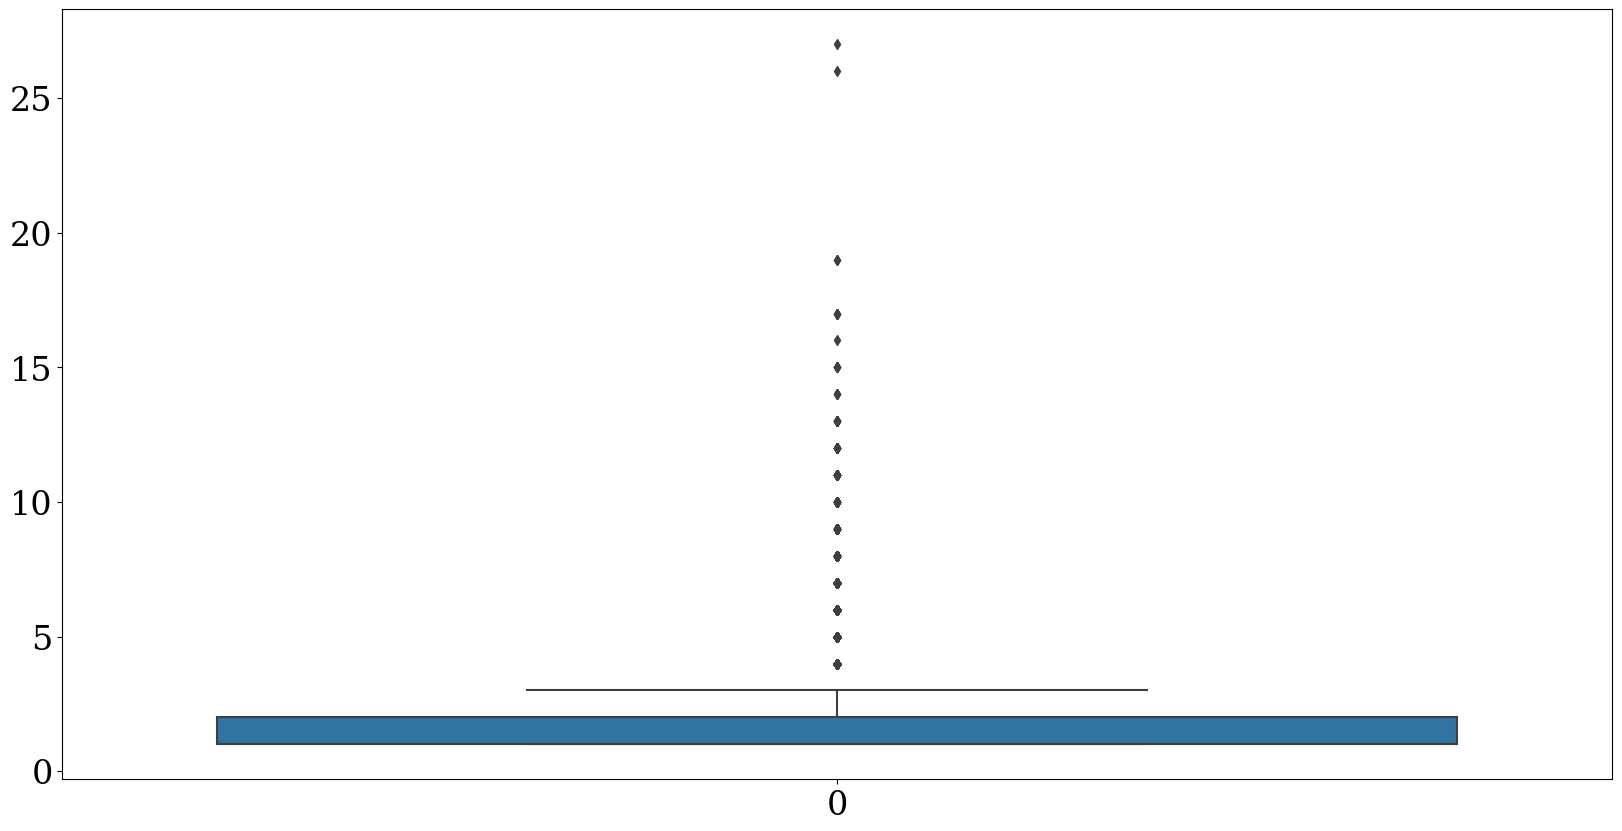

In [15]:
# how well does it work if we randomly pick one cds for each gene and use that to re-annotate?

# this can be run several times to get the distribution

df=pd.read_csv(clean_gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
cdf=df[df["type"]=="CDS"].reset_index(drop=True)
cdf["tid"]=cdf["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
cdf["gid"]=cdf["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]

rdf = cdf[~cdf["gid"].isnull()][["tid",
                               "gid"]].drop_duplicates(keep="first").groupby(by="gid").agg({"tid":["count",
                                                                                                         lambda grp: set(grp)]}).reset_index()
rdf.columns = ["gid","count","list"]

print("total number of genes with CDS in them: "+str(len(rdf)))
print("total number of transcript with CDS: "+str(rdf["count"].sum()))
print("number of genes with multiple coding isoforms: "+str(len(rdf[rdf["count"]>1])))
print("number of transcripts in genes with multiple coding isoforms: "+str(rdf[rdf["count"]>1]["count"].sum()))

mrdf = rdf[rdf["count"]>1].reset_index(drop=True)

sns.boxplot(rdf["count"])

In [ ]:
num_rands = 10
percs = [0,0.25,0.50,0.75]
out_gtf_fname = outdir+"orf.gtf"

ref_gids = set(mrdf["gid"])

for p in percs:
    for i in range(num_rands):
        # for each gene get 1 random CDS and everything else
        ref_tids = set()
        q_tids = set()
        for idx,row in mrdf.iterrows():
            nrs = int(max(1,float(len(list(row["list"])))*p))
            rs = random.sample(list(row["list"]),nrs)
            for r in rs:
                ref_tids.add(r)
            for v in row["list"]:
                if v in rs:
                    continue
                else:
                    q_tids.add(v)

        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"

        with open(rand_gtf_fname,"w+") as outFP:
            with open(clean_gtf_fname,"r") as inFP:
                for line in inFP:
                    lcs = line.split("\t")
                    if not len(lcs) == 9:
                        continue

                    tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
                    if tid in ref_tids:
                        outFP.write(line)
                    else:
                        if tid in q_tids:
                            if not lcs[2]=="CDS":
                                outFP.write(line)

        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        cmd = [orfanage_bin,
               "--reference",fa_fname,
               "--query",rand_gtf_fname,
               "--threads",str(num_threads),
               "--output",rand_orf_gtf_fname,
               "--non_aug",
               "--keep_cds",
               rand_gtf_fname]
        print(" ".join(cmd))
        subprocess.call(cmd)

In [19]:
# load reference chains
ref_df = definitions.get_chains(clean_gtf_fname,"CDS",True)

res = dict()
res_ilpd = pd.DataFrame()

for p in percs:
    for i in range(num_rands):
        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"
        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        # load orf and compare to red
        q_df = definitions.get_chains(rand_orf_gtf_fname,"CDS",False)
        q_adf = definitions.get_attribute(rand_orf_gtf_fname,"orfanage_template")
        q_df = q_df.merge(q_adf,on="tid",how='left')
        comp_df = q_df.merge(ref_df,on="tid",how="left")
        comp_df.columns = ["tid","orf_has_cds","orf_chain","orf_templ","ref_has_cds","seqid","strand","coords","ref_chain"]
        comp_df[["mod_chain",
                "c1len",
                "c2len",
                "match_start",
                "match_end",
                "num_bp_extra",
                "num_bp_missing",
                "num_bp_inframe",
                "num_bp_match",
                "num_bp_outframe",
                "lpd",
                "ilpd",
                "mlpd"]] = comp_df.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["ref_chain"],row["strand"]),axis=1)
        comp_df.drop(["match_start","match_end","num_bp_match","lpd","mlpd"],axis=1,inplace=True)
        
        ilpd_df = comp_df[["ilpd"]].reset_index(drop=True)
        ilpd_df["perc"] = p
        ilpd_df["iter"] = i
        res_ilpd = pd.concat([res_ilpd,ilpd_df],axis=0)

        # get some numbers
        nmt = len(comp_df[(comp_df["ref_has_cds"]==1)&(comp_df["orf_has_cds"]==0)]) # number of missing CDS
        nmr = len(comp_df[comp_df["ref_chain"]==comp_df["orf_chain"]]) # number with matching chains
        nnr = len(comp_df[~(comp_df["ref_chain"]==comp_df["orf_chain"])]) # number with mis-matching chains
        mean_ilpd = comp_df["ilpd"].mean()

        res[str(i)+"."+str(p)] = [i,p,nmt,nmr,nnr,mean_ilpd]
        
res_ilpd.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t",index=False)

res = pd.DataFrame.from_dict(res,orient="index").reset_index()
res.columns = ["idx","iter","perc","missing","matching","mismatching","mean_ilpd"]
res.drop("idx",axis=1,inplace=True)
res.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t",index=False)
for v in res.columns:
    print(v+": mean ",str(res[v].mean())+","+str(res[v].std()))
res.head()

iter: mean  4.5,2.908872369413698
perc: mean  0.375,0.28306925853614895
missing: mean  5.65,3.620100579421544
matching: mean  29390.7,632.3537714821446
mismatching: mean  1838.15,631.6867346788523
mean_ilpd: mean  99.01129059050037,0.38366411726642563


,iter,perc,missing,matching,mismatching,mean_ilpd
0,0,0.0,10,28704,2523,98.526948
1,1,0.0,11,28779,2450,98.676294
2,2,0.0,15,28758,2469,98.607263
3,3,0.0,6,28639,2588,98.484517
4,4,0.0,10,28827,2402,98.630728


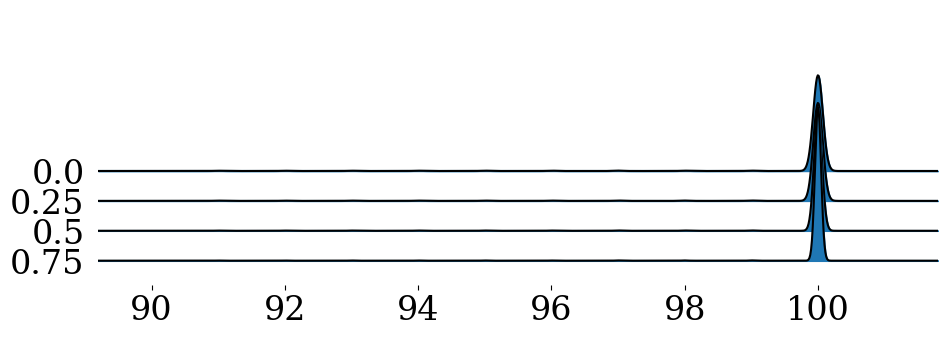

In [20]:
res_ilpd = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t")
res = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t")

fig,axes = joyplot(res_ilpd[res_ilpd["ilpd"]>90][["perc","ilpd"]],by='perc',column='ilpd',figsize=(10,4))
plt.show()